# GBM - Multiple Targets
- Data Split 
    - Apply 80/20 split by Ticker
    - For calculating performance, use 5 fold cross validation targetting RMSE
- Build GBM by Ticker
- Make prediction for close at T+1 - T+5

In [43]:
import xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
TICKER = "NVDA"
TEST_FRAC = 0.20
RESPONSE_VARS = [f"close_t+{day}" for day in range(1, 6)]

In [45]:
df = pd.read_parquet("../data/processed/daily_with_finbert_and_indicators.parquet")

In [46]:
df["ticker"].unique()

array(['AAPL', 'AMZN', 'HD', 'JPM', 'KO', 'MSFT', 'NVDA', 'TSLA', 'UNH',
       'XOM'], dtype=object)

In [47]:
df = df.query(f"ticker == '{TICKER}'").reset_index(drop=True)

In [48]:
df.shape

(249, 805)

In [49]:
df.head()

,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,open_smoothed_alpha:0.9,close_smoothed_alpha:0.25,close_smoothed_alpha:0.75,close_smoothed_alpha:0.9,return_t+1_smoothed_alpha:0.25,return_smoothed_alpha:0.25,return_t+1_smoothed_alpha:0.75,return_smoothed_alpha:0.75,return_t+1_smoothed_alpha:0.9,return_smoothed_alpha:0.9
0,NVDA,2024-05-01,85.077003,86.000000,81.254997,83.041000,559863000.0,0.033429,[],0.000000,...,85.077003,83.041000,83.041000,83.041000,0.033429,0.006539,0.033429,0.003877,0.033429,0.003447
1,NVDA,2024-05-02,84.448997,86.237000,83.199997,85.817001,377898000.0,0.034632,[],0.000000,...,84.511798,83.735001,85.123001,85.539401,0.033730,0.033429,0.034331,0.033429,0.034512,0.033429
2,NVDA,2024-05-03,87.789001,89.280998,87.040001,88.789001,398341000.0,0.037741,[],0.000000,...,87.461281,84.998501,87.872501,88.464041,0.034733,0.033730,0.036889,0.034331,0.037418,0.034512
3,NVDA,2024-05-06,89.389999,92.220001,89.055000,92.139999,376203000.0,-0.017213,[],0.000000,...,89.197128,86.783875,91.073125,91.772404,0.021746,0.034733,-0.003688,0.036889,-0.011750,0.037418
4,NVDA,2024-05-07,91.098000,91.780998,89.011002,90.554001,437342000.0,-0.001568,"[Microchip (MCHP) Q4 Earnings Meet Estimates, ...",0.233307,...,90.907912,87.726407,90.683782,90.675841,0.015918,0.021746,-0.002098,-0.003688,-0.002586,-0.011750


In [50]:
df.tail()

,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,open_smoothed_alpha:0.9,close_smoothed_alpha:0.25,close_smoothed_alpha:0.75,close_smoothed_alpha:0.9,return_t+1_smoothed_alpha:0.25,return_smoothed_alpha:0.25,return_t+1_smoothed_alpha:0.75,return_smoothed_alpha:0.75,return_t+1_smoothed_alpha:0.9,return_smoothed_alpha:0.9
244,NVDA,2025-04-23,104.519997,104.800003,102.019997,102.709999,247526000.0,0.036218,[Ultimate Insider Marjorie Taylor Greene’s #3 ...,0.086995,...,103.951654,102.669532,101.721667,102.313155,0.010204,0.001532,0.034704,0.030160,0.036213,0.036167
245,NVDA,2025-04-24,103.480003,106.540001,103.110001,106.430000,220815000.0,0.043033,"[Alphabet Q1: Excellent Results, Strong Buy, N...",0.141677,...,103.527168,103.609649,105.252917,106.018316,0.018411,0.010204,0.040951,0.034704,0.042351,0.036213
246,NVDA,2025-04-25,106.849998,111.919998,105.730003,111.010002,251064700.0,-0.020539,[Pope Francis Modernized the Vatican’s Investm...,0.034299,...,106.517715,105.459737,109.570731,110.510833,0.008674,0.018411,-0.005166,0.040951,-0.014250,0.042351
247,NVDA,2025-04-28,109.690002,110.370003,106.019997,108.730003,207708500.0,0.002667,[Nvidia Stock Falls. This Huawei Breakthrough ...,-0.096461,...,109.372774,106.277304,108.940185,108.908086,0.007172,0.008674,0.000709,-0.005166,0.000975,-0.014250
248,NVDA,2025-04-29,107.669998,110.199997,107.440002,109.019997,170444300.0,-0.000917,[Nvidia stock dips amid Reuters report on AI c...,0.126962,...,107.840276,106.962977,109.000044,109.008806,0.005150,0.007172,-0.000511,0.000709,-0.000728,0.000975


<Axes: >

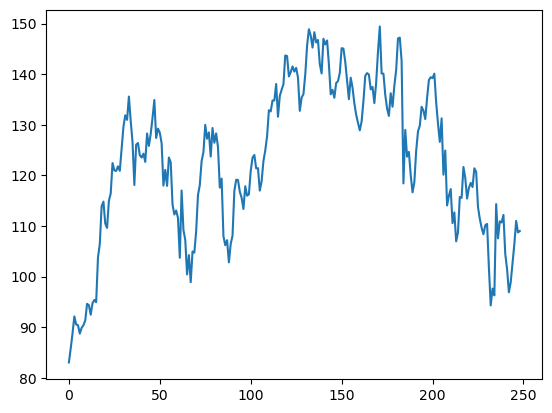

In [51]:
df["close"].plot()

## Add Close @ T+1 through T+5 as variables to test modeling
- Observe performance when predicting days in advance
- How to build a strategy with this approach?

In [52]:
for lag in range(1, 6):
    df[f"close_t+{lag}"] = df["close"].shift(-lag)

In [53]:
df[["close", *[f"close_t+{day}" for day in range(1, 6)]]].head(10)

,close,close_t+1,close_t+2,close_t+3,close_t+4,close_t+5
0,83.041000,85.817001,88.789001,92.139999,90.554001,90.412003
1,85.817001,88.789001,92.139999,90.554001,90.412003,88.747002
2,88.789001,92.139999,90.554001,90.412003,88.747002,89.877998
3,92.139999,90.554001,90.412003,88.747002,89.877998,90.399002
4,90.554001,90.412003,88.747002,89.877998,90.399002,91.356003
5,90.412003,88.747002,89.877998,90.399002,91.356003,94.629997
6,88.747002,89.877998,90.399002,91.356003,94.629997,94.359001
7,89.877998,90.399002,91.356003,94.629997,94.359001,92.478996
8,90.399002,91.356003,94.629997,94.359001,92.478996,94.779999
9,91.356003,94.629997,94.359001,92.478996,94.779999,95.386002


In [54]:
df[["close", *[f"close_t+{day}" for day in range(1, 6)]]].tail(10)

,close,close_t+1,close_t+2,close_t+3,close_t+4,close_t+5
239,112.199997,104.489998,101.489998,96.910004,98.889999,102.709999
240,104.489998,101.489998,96.910004,98.889999,102.709999,106.430000
241,101.489998,96.910004,98.889999,102.709999,106.430000,111.010002
242,96.910004,98.889999,102.709999,106.430000,111.010002,108.730003
243,98.889999,102.709999,106.430000,111.010002,108.730003,109.019997
244,102.709999,106.430000,111.010002,108.730003,109.019997,NaN
245,106.430000,111.010002,108.730003,109.019997,NaN,NaN
246,111.010002,108.730003,109.019997,NaN,NaN,NaN
247,108.730003,109.019997,NaN,NaN,NaN,NaN
248,109.019997,NaN,NaN,NaN,NaN,NaN


In [55]:
df.dropna(subset=RESPONSE_VARS, inplace=True)

### Apply data split
- For initial test, build model on 80% and validate on 20% OOT
    - Tune hyperparameters using CV on Train set

- For future, always validate on most recent 2-months and add additional 

In [56]:
df = df.query(f"ticker == '{TICKER}'").reset_index(drop=True)

In [57]:
df = df.sort_values("date")

In [58]:
train = df.loc[df.index <= int(df.shape[0] * (1 - TEST_FRAC)), :]
test = df.loc[df.index > int(df.shape[0] * (1 - TEST_FRAC)), :]

In [59]:
train.shape, test.shape

((196, 810), (48, 810))

### Build initial models on each `close` variables
- Use ARIMA as a baseline (and potentially use as a feature)

In [60]:
keys = ["ticker", "date"]
non_modeling_vars = ["headlines", *[col for col in df.columns if "_t+" in col]]
print(non_modeling_vars)

['headlines', 'return_t+1', 'return_t+1_smoothed_alpha:0.25', 'return_t+1_smoothed_alpha:0.75', 'return_t+1_smoothed_alpha:0.9', 'close_t+1', 'close_t+2', 'close_t+3', 'close_t+4', 'close_t+5']


In [61]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np

# Store results
results = {}
feature_importances_lists = {}
best_rounds = {}

# Specify predictors
X = train.drop(columns=keys + non_modeling_vars)

for target in RESPONSE_VARS:

    # Store results for each target in a dictionary
    results[target] = []
    feature_importances_lists[target] = []
    best_rounds[target] = []

    # Prepare the target
    y = train[target]

    # XGBoost parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 5,
        'learning_rate': 0.1
    }

    # TimeSeriesSplit for sequential cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        print(f"\n=== Fold {fold + 1} ===")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_test, label=y_test)

        # Train model with early stopping using validation fold
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=250,
            evals=[(dvalid, "eval")],
            early_stopping_rounds=10,
            verbose_eval=25
        )

        best_rounds[target].append(model.best_iteration)

        # Predict on test set
        y_pred = model.predict(dvalid)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        print(f"Fold RMSE: {rmse:.4f}")
        results[target].append(rmse)

        # Get and sort feature importances
        feature_importances = model.get_score(importance_type='weight')
        sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
        feature_importances_lists[target].append(dict(sorted_importances))

    # Final results
    average_rmse = np.mean(results[target])
    print(f"\nAverage RMSE across all folds for {target}: {average_rmse:.4f}")




=== Fold 1 ===
[0]	eval-rmse:103.93562
[25]	eval-rmse:7.71865
[43]	eval-rmse:6.13321
Fold RMSE: 6.1683

=== Fold 2 ===
[0]	eval-rmse:124.09543
[25]	eval-rmse:21.55873
[50]	eval-rmse:14.14359
[75]	eval-rmse:13.48577
[100]	eval-rmse:13.41469
[125]	eval-rmse:13.40326
[146]	eval-rmse:13.40238
Fold RMSE: 13.4023

=== Fold 3 ===
[0]	eval-rmse:121.86315
[25]	eval-rmse:11.38676
[50]	eval-rmse:5.65526
[75]	eval-rmse:5.54608
Fold RMSE: 5.5461

Average RMSE across all folds for close_t+1: 8.3722

=== Fold 1 ===
[0]	eval-rmse:104.35577
[25]	eval-rmse:7.53701
[40]	eval-rmse:7.24889
Fold RMSE: 7.3227

=== Fold 2 ===
[0]	eval-rmse:124.98600
[25]	eval-rmse:25.01635
[50]	eval-rmse:17.86103
[75]	eval-rmse:17.34145
[100]	eval-rmse:17.26845
[125]	eval-rmse:17.25804
[150]	eval-rmse:17.25702
[164]	eval-rmse:17.25694
Fold RMSE: 17.2569

=== Fold 3 ===
[0]	eval-rmse:121.84507
[25]	eval-rmse:12.73066
[50]	eval-rmse:7.31765
[75]	eval-rmse:7.26080
[84]	eval-rmse:7.26175
Fold RMSE: 7.2618

Average RMSE across al

In [62]:
# === Final Feature Selection Across Targets ===
top_n = 50  # Number of top features to consider
intersections_by_target = {}

# Step 1: Intersect across folds for each target
for target in RESPONSE_VARS:
    top_features_per_fold = [
        list(feats.keys())[:top_n]
        for feats in feature_importances_lists[target]
    ]
    # Intersect across 3 folds
    intersection = set(top_features_per_fold[0])
    for feature_list in top_features_per_fold[1:]:
        intersection = intersection.intersection(feature_list)
    intersections_by_target[target] = intersection
    print(f"{target}: {len(intersection)} features in fold intersection")

close_t+1: 8 features in fold intersection
close_t+2: 7 features in fold intersection
close_t+3: 11 features in fold intersection
close_t+4: 8 features in fold intersection
close_t+5: 6 features in fold intersection


In [63]:
intersections_by_target["close_t+1"]

{'finbert_1',
 'finbert_253',
 'finbert_4',
 'high',
 'low',
 'open',
 'return_smoothed_alpha:0.9',
 'volume'}

## Build model on full training set with only overlapping features
- Evaluate on test set

In [64]:
final_models = {}
final_predictions = {}
final_feature_importances = {}

for target in RESPONSE_VARS:
    print(f"\nTraining final model for {target}")

    # Get final features for this target
    selected_features = list(intersections_by_target[target])
    
    # Prepare training and full data
    X = df[selected_features]
    y = df[target]
    X_train = train[selected_features]
    y_train = train[target]

    # Estimate optimal number of boosting rounds
    rounds = int(sum(best_rounds[target]) / len(best_rounds[target]))

    # Set parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 5,
        'learning_rate': 0.1,
    }

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dfull = xgb.DMatrix(X)

    # Train model
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=rounds
    )

    # Store model and predictions
    final_models[target] = model
    final_predictions[target] = model.predict(dfull)
    df[f"pred_{target}"] = final_predictions[target]

    # Store sorted feature importances
    feature_importances = model.get_score(importance_type='gain')
    sorted_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
    final_feature_importances[target] = sorted_importance

    print(f"    Done training {target} with {len(selected_features)} features and {rounds} rounds.")



Training final model for close_t+1
    Done training close_t+1 with 8 features and 78 rounds.

Training final model for close_t+2
    Done training close_t+2 with 7 features and 86 rounds.

Training final model for close_t+3
    Done training close_t+3 with 11 features and 127 rounds.

Training final model for close_t+4
    Done training close_t+4 with 8 features and 79 rounds.

Training final model for close_t+5
    Done training close_t+5 with 6 features and 69 rounds.


In [65]:
df[["close", *[f"pred_close_t+{day}" for day in range(1, 6)]]].tail()

,close,pred_close_t+1,pred_close_t+2,pred_close_t+3,pred_close_t+4,pred_close_t+5
239,112.199997,108.267006,112.334190,122.233757,125.281311,127.561371
240,104.489998,102.043068,106.896042,109.357582,121.156479,129.020950
241,101.489998,102.384254,109.892372,117.402946,119.809891,125.981689
242,96.910004,102.176682,107.764130,119.375824,120.387329,125.809502
243,98.889999,100.095398,108.023193,117.328987,119.553680,124.917076


### Plot predictions on train going into test set
- What % of the time is the prediction directionally correct?
- How accurate is the prediction?

In [66]:
TEST_START_INDEX = 200

In [67]:
def evaluate_weighted_strategy(df, prediction_prefix="pred_close_t+", actual_col="close", max_horizon=5,
                                weights=None, buy_thresh=0.005, sell_thresh=-0.005):
    """
    Evaluate a strategy using a weighted average of predicted returns across multiple horizons.
    
    Strategy:
        For each day:
            If weighted average 5-day return > today's close price:
                Buy
            else:
                Sell

    Evaluation:
        Compare returns vs. holding for the evaluation period


    Args:
        df (pd.DataFrame): Input dataframe with predicted close prices.
        prediction_prefix (str): Prefix of prediction columns (e.g., "pred_close_t+").
        actual_col (str): Column with today's actual price.
        max_horizon (int): Max number of prediction horizons (e.g., 5 for t+1 to t+5).
        weights (list or np.array): Weights for each horizon (default: uniform).
        buy_thresh (float): Threshold to trigger a buy signal.
        sell_thresh (float): Threshold to trigger a sell signal.

    Returns:
        None (displays plots and metrics)
    """
    df = df.copy()

    # Weights to apply to each time horizon
    if weights is None:
        weights = np.ones(max_horizon) / max_horizon
    weights = np.array(weights)
    assert len(weights) == max_horizon, "Length of weights must match max_horizon"

    # Compute predicted close for each horizon
    pred_columns = [f"{prediction_prefix}{h}" for h in range(1, max_horizon + 1)]
    assert all(col in df.columns for col in pred_columns), "All predicted columns must be in df"

    # Weighted average of predicted close
    df["weighted_predicted_close"] = df[pred_columns].dot(weights)
    df["actual_close"] = df[f"{actual_col}_t+{max_horizon}"]

    # Define trading signal
    df["signal"] = np.select(
        [
            # Buy if weighted average prediction is at least X% higher than current close
            np.divide(df["weighted_predicted_close"], df["actual_close"]) > 1 + buy_thresh,
            # Sell if weighted average prediction is at least X% lower than current close
            1 - np.divide(df["weighted_predicted_close"], df["actual_close"]) < sell_thresh,
        ],
        [1, -1],  # Buy = 1, Sell = -1
        default=0  # Hold
    )

    # Compute realized return over max_horizon
    future_col = f"{actual_col}_t+{max_horizon}"
    df["actual_return"] = (df[future_col] - df[actual_col]) / df[actual_col]

    # Strategy return = actual return * signal
    df["strategy_return"] = df["actual_return"] * df["signal"]


      # Cumulative returns
    df["cumulative_market"] = (1 + df["actual_return"].fillna(0)).cumprod()
    df["cumulative_strategy"] = (1 + df["strategy_return"].fillna(0)).cumprod()

    # === Plot ===
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["cumulative_market"], label="Market (Buy & Hold)", color='blue')
    plt.plot(df["date"], df["cumulative_strategy"], label="Model Strategy", color='orange')
    plt.axhline(1, color='gray', linestyle='--', linewidth=0.8)
    plt.title(f"Trading Strategy Based on Weighted Prediction ({max_horizon}-Day Horizon)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    # Format x-axis: show every 5th date
    plt.xticks(ticks=df["date"].iloc[::5], rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === Metrics ===
    sharpe = df["strategy_return"].mean() / df["strategy_return"].std()
    win_rate = (df["strategy_return"] > 0).mean()

    print(f"📈 Strategy Performance over {max_horizon} days:")
    print(f"→ Sharpe Ratio: {sharpe:.2f}")
    print(f"→ Win Rate: {win_rate:.2%}")
    print("-" * 40)


In [68]:
def plot_predictions_vs_actual(df, actual_col='close_t+5', prediction_prefix='pred_close_t+', max_horizon=5):
    """
    Plots the actual t+5 close price against all predicted closes from t+1 through t+5.
    """
    plt.figure(figsize=(12, 6))

    # Plot actual t+5 close
    plt.plot(df["date"], df[actual_col], label='Actual Close t+5', linewidth=2, color='black')

    # Plot each prediction t+1 through t+5
    for i in range(1, max_horizon + 1):
        pred_col = f"{prediction_prefix}{i}"
        if pred_col in df.columns:
            plt.plot(df["date"], df[pred_col], label=f"Pred Close t+{i}", linestyle='--')

    plt.xlabel("Date")
    plt.ylabel("Price")
    # Format x-axis: show every 5th date
    plt.xticks(ticks=df["date"].iloc[::5], rotation=45)
    plt.title("Predicted Closes vs Actual Close at t+5")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


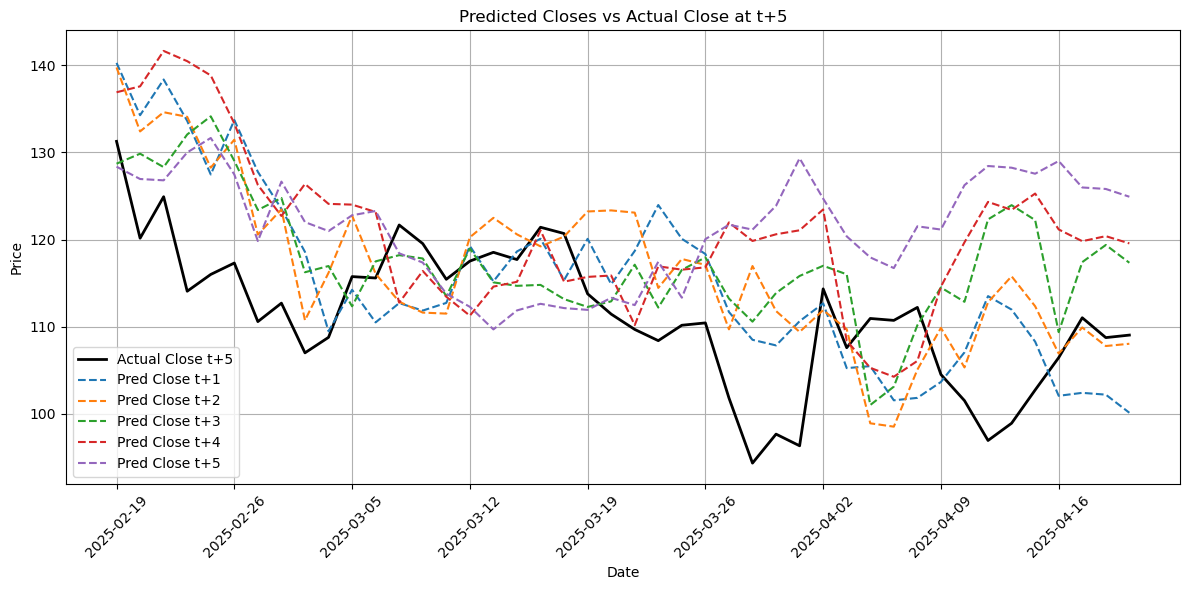

In [69]:
plot_predictions_vs_actual(
    df=df.iloc[TEST_START_INDEX:],
    actual_col='close_t+5',
    prediction_prefix='pred_close_t+',
    max_horizon=5
)

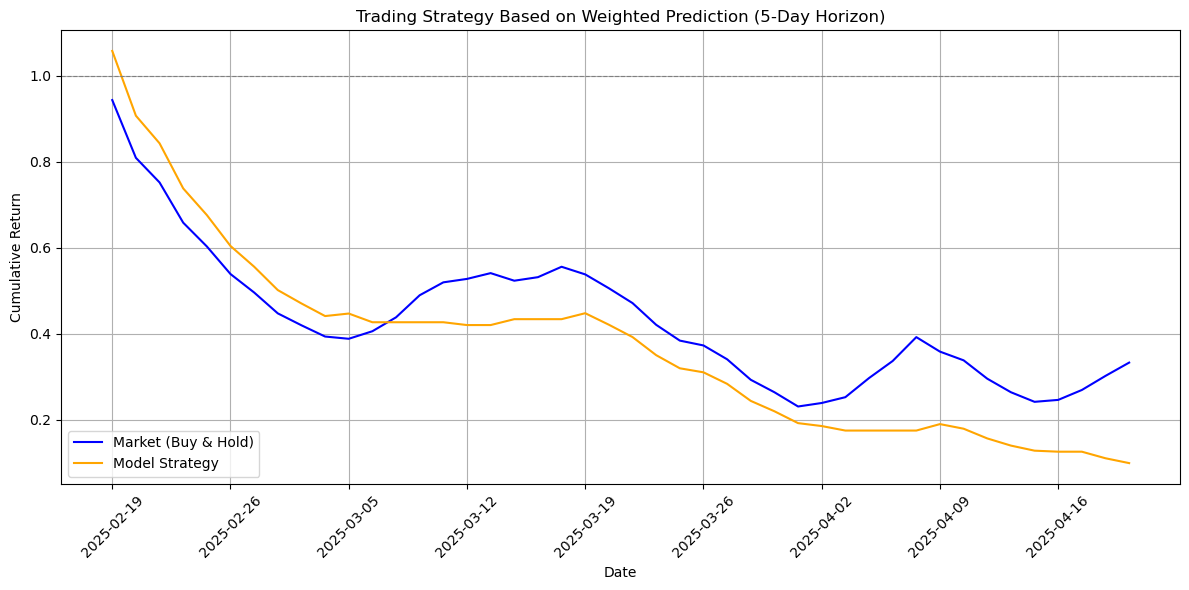

📈 Strategy Performance over 5 days:
→ Sharpe Ratio: -0.87
→ Win Rate: 11.36%
----------------------------------------


In [70]:
evaluate_weighted_strategy(
    df=df.iloc[TEST_START_INDEX:],
    prediction_prefix="pred_close_t+",
    max_horizon=5,
    weights=[0.40, 0.30, 0.15, 0.10, 0.05],  # Exponential decay style weights
    buy_thresh=0.05,
    sell_thresh=0.01
)
